## Imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from data_process.file_wrapper import FileWrapper
from data_process.utils import get_by_path
from data_process.signal_tools import signal_manip
%matplotlib widget

## Get data and find average sample rate

In [21]:
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10.pkl')
data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12.pkl')

imu_topic = '/imu/raw'

a_x = get_by_path(data.data, [imu_topic, 'linear_acceleration', 'x'])
a_y = get_by_path(data.data, [imu_topic, 'linear_acceleration', 'y'])
a_z = get_by_path(data.data, [imu_topic, 'linear_acceleration', 'z'])
g_x = get_by_path(data.data, [imu_topic, 'angular_velocity', 'x'])
g_y = get_by_path(data.data, [imu_topic, 'angular_velocity', 'y'])
g_z = get_by_path(data.data, [imu_topic, 'angular_velocity', 'z'])
time = get_by_path(data.data, [imu_topic, 'time'])

sample_rate = 1 / np.average(time[1:len(time)] - time[0:len(time)-1])
# sample_rate = np.round(sample_rate)
time_new = np.arange(time[0], time[-1], 1 / sample_rate)

Loading from pickle file...


## Plot time differences

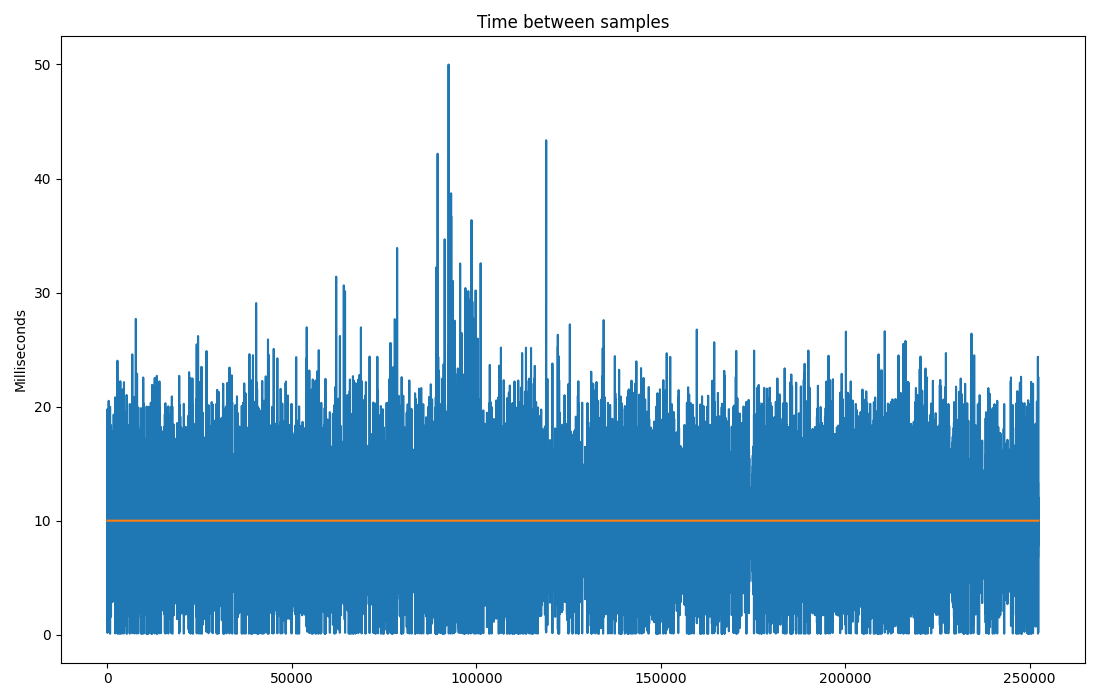

In [22]:
time_fig = plt.figure(1)
time_fig.clear()
plt.plot(1000 * (time[1:len(time)] - time[0:len(time)-1]))
plt.plot(1000 * (time_new[1:len(time_new)] - time_new[0:len(time_new)-1]))
plt.ylabel('Milliseconds')
plt.title('Time between samples')
time_fig.set_size_inches(11, 7)
time_fig.tight_layout()
plt.show()

## Interpolate

In [23]:
a_x_lin, a_y_lin, a_z_lin, g_x_lin, g_y_lin, g_z_lin = \
    signal_manip.interp(time, [a_x, a_y, a_z, g_x, g_y, g_z], time_new, interp_method='linear')

a_x_cspl, a_y_cspl, a_z_cspl, g_x_cspl, g_y_cspl, g_z_cspl = \
    signal_manip.interp(time, [a_x, a_y, a_z, g_x, g_y, g_z], time_new, interp_method='cubic_spline')

a_x_bspl, a_y_bspl, a_z_bspl, g_x_bspl, g_y_bspl, g_z_bspl = \
    signal_manip.interp(time, [a_x, a_y, a_z, g_x, g_y, g_z], time_new, interp_method='b_spline')

## Plot result

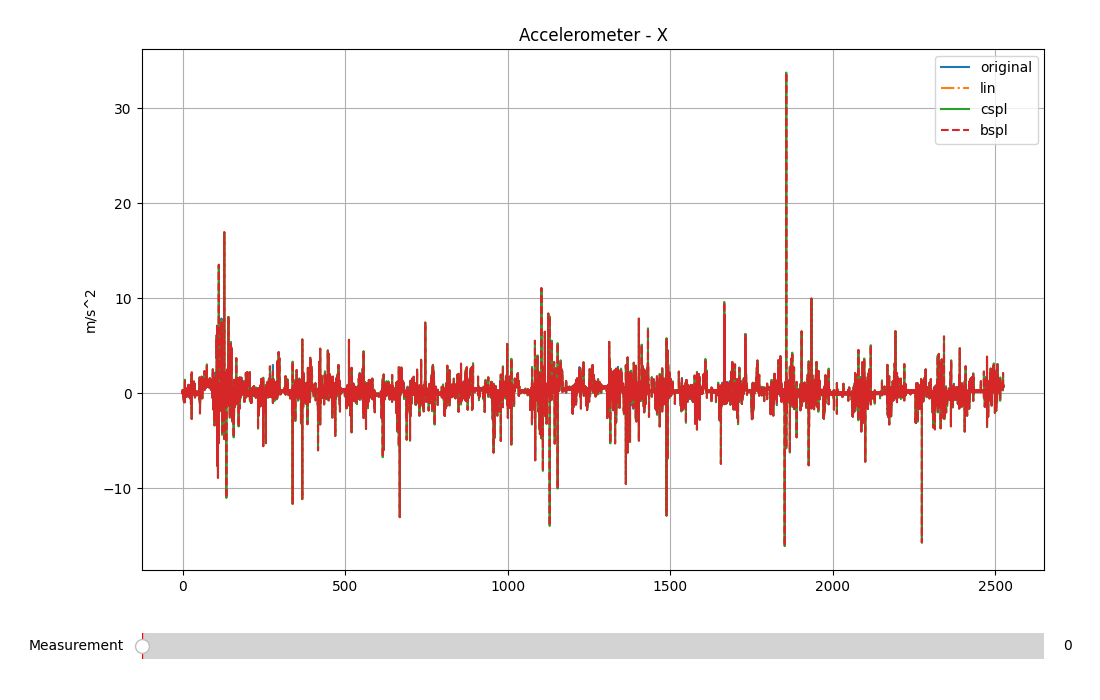

In [24]:
interp_fig = plt.figure(2)
interp_fig.clear()
gs_kw = dict(height_ratios=[1, 0.1])
interp_fig, interp_ax = plt.subplot_mosaic(num=2, mosaic=[['plot'],
                                                          ['slider']], gridspec_kw=gs_kw)

measurement_slider = Slider(ax=interp_ax['slider'], label='Measurement', 
                            valmin=0, 
                            valmax=5, 
                            valinit=0, 
                            valstep=1)

data = [a_x, a_y, a_z, g_x, g_y, g_z]
data_lin  = [a_x_lin, a_y_lin, a_z_lin, g_x_lin, g_y_lin, g_z_lin]
data_cspl = [a_x_cspl, a_y_cspl, a_z_cspl, g_x_cspl, g_y_cspl, g_z_cspl]
data_bspl = [a_x_bspl, a_y_bspl, a_z_bspl, g_x_bspl, g_y_bspl, g_z_bspl]
def change_plot(idx):
    interp_ax['plot'].clear()

    interp_ax['plot'].plot(time, data[idx])
    interp_ax['plot'].plot(time_new, data_lin[idx], '-.')
    interp_ax['plot'].plot(time_new, data_cspl[idx])
    interp_ax['plot'].plot(time_new, data_bspl[idx], '--')
    interp_ax['plot'].grid(which='both', axis='both')
    interp_ax['plot'].legend(['original','lin', 'cspl', 'bspl'])

    if idx < 3:
        interp_ax['plot'].set_ylabel('m/s^2')
        measurement = 'Accelerometer'
    else:
        interp_ax['plot'].set_ylabel('rad/s')
        measurement = 'Gyroscope'

    if idx % 3 == 0:
        title = measurement + ' - X'
    elif idx % 3 == 1:
        title = measurement + ' - Y'
    else:
        title = measurement + ' - Z'

    interp_ax['plot'].set_title(title)


change_plot(0)
measurement_slider.on_changed(change_plot)

interp_fig.set_size_inches(11, 7)
interp_fig.tight_layout(pad=2.0)

plt.show()